### Import Libraries

In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

print(os.listdir("data"))

['.ipynb_checkpoints', 'hmnist_28_28_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_1', 'ham10000_images_part_2', 'hmnist_8_8_RGB.csv', 'ISIC2018_Task3_Test_Images', 'HAM10000_metadata.csv', 'hmnist_8_8_L.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1']


## Step 1. Data analysis and preprocessing

In [2]:
data_dir = 'data'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [4]:
# norm_mean,norm_std = compute_img_mean_std(all_image_path)

norm_mean = [0.7628285, 0.54633135, 0.57070315]
norm_std = [0.14125358, 0.15315984, 0.17052305]

In [5]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,data/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [6]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [7]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,data/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [8]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [9]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [10]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [11]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: cell_type_idx, dtype: int64

In [12]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [13]:
df_train['cell_type_idx'].value_counts()

4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: cell_type_idx, dtype: int64

In [14]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

In [15]:
# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

Melanocytic nevi                  5822
Dermatofibroma                    5350
dermatofibroma                    5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

In [16]:
# # We can split the test set again in a validation set and a true test set:
# df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
# df_test = df_test.reset_index()

## Step 2. Model building

In [17]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [18]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet201
        """
        model_ft = models.densenet201(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [19]:
# resnet,vgg,densenet,inception
model_name = 'densenet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [20]:
# norm_mean = (0.49139968, 0.48215827, 0.44653124)
# norm_std = (0.24703233, 0.24348505, 0.26158768)
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [21]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [22]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=32)#4)
# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=32)#4)

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
training_set.df.cell_type_idx.to_numpy()

array([2, 2, 2, ..., 6, 6, 6], dtype=int8)

In [24]:
# we use SGD optimizer, use cross entropy loss as our loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=training_set.df.cell_type_idx.unique(),
#     y=training_set.df.cell_type_idx.to_numpy())
# criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).cuda(),
#                                 reduction='mean').to(device)
criterion = nn.CrossEntropyLoss().to(device)

## Step 3. Model training

In [25]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [27]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [28]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 1124], [train loss 1.79304], [train acc 0.31781]
[epoch 1], [iter 200 / 1124], [train loss 1.63805], [train acc 0.41063]
[epoch 1], [iter 300 / 1124], [train loss 1.50678], [train acc 0.46656]
[epoch 1], [iter 400 / 1124], [train loss 1.39296], [train acc 0.51172]
[epoch 1], [iter 500 / 1124], [train loss 1.30241], [train acc 0.54256]
[epoch 1], [iter 600 / 1124], [train loss 1.22670], [train acc 0.56901]
[epoch 1], [iter 700 / 1124], [train loss 1.16480], [train acc 0.59121]
[epoch 1], [iter 800 / 1124], [train loss 1.11178], [train acc 0.60879]
[epoch 1], [iter 900 / 1124], [train loss 1.06493], [train acc 0.62448]
[epoch 1], [iter 1000 / 1124], [train loss 1.02304], [train acc 0.63944]
[epoch 1], [iter 1100 / 1124], [train loss 0.98782], [train acc 0.65151]
------------------------------------------------------------
[epoch 1], [val loss 0.38036], [val acc 0.87220]
------------------------------------------------------------
***********************************

------------------------------------------------------------
[epoch 8], [val loss 0.30714], [val acc 0.90435]
------------------------------------------------------------
[epoch 9], [iter 100 / 1124], [train loss 0.10613], [train acc 0.96781]
[epoch 9], [iter 200 / 1124], [train loss 0.11039], [train acc 0.96266]
[epoch 9], [iter 300 / 1124], [train loss 0.11021], [train acc 0.96365]
[epoch 9], [iter 400 / 1124], [train loss 0.11011], [train acc 0.96352]
[epoch 9], [iter 500 / 1124], [train loss 0.11154], [train acc 0.96294]
[epoch 9], [iter 600 / 1124], [train loss 0.11072], [train acc 0.96318]
[epoch 9], [iter 700 / 1124], [train loss 0.10967], [train acc 0.96357]
[epoch 9], [iter 800 / 1124], [train loss 0.10940], [train acc 0.96348]
[epoch 9], [iter 900 / 1124], [train loss 0.10843], [train acc 0.96385]
[epoch 9], [iter 1000 / 1124], [train loss 0.10754], [train acc 0.96416]
[epoch 9], [iter 1100 / 1124], [train loss 0.10748], [train acc 0.96426]
-----------------------------------

In [29]:
torch.save(model.state_dict(), 
           '/data/MNIST-Skin-Cancer-with-Jetson/model_densenet201_SGD_lr_workers.pth')

## Step 4. Model evaluation

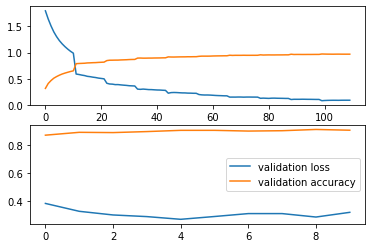

In [30]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

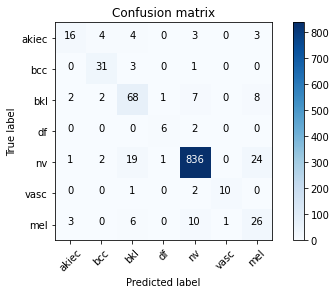

In [32]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [33]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.73      0.53      0.62        30
         bcc       0.79      0.89      0.84        35
         bkl       0.67      0.77      0.72        88
          df       0.75      0.75      0.75         8
          nv       0.97      0.95      0.96       883
        vasc       0.91      0.77      0.83        13
         mel       0.43      0.57      0.49        46

    accuracy                           0.90      1103
   macro avg       0.75      0.75      0.74      1103
weighted avg       0.91      0.90      0.90      1103



Text(0, 0.5, 'Fraction classified incorrectly')

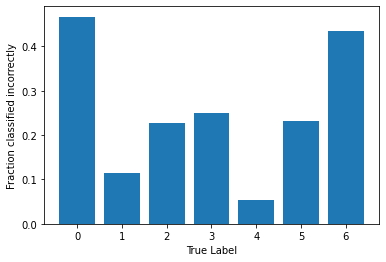

In [34]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')